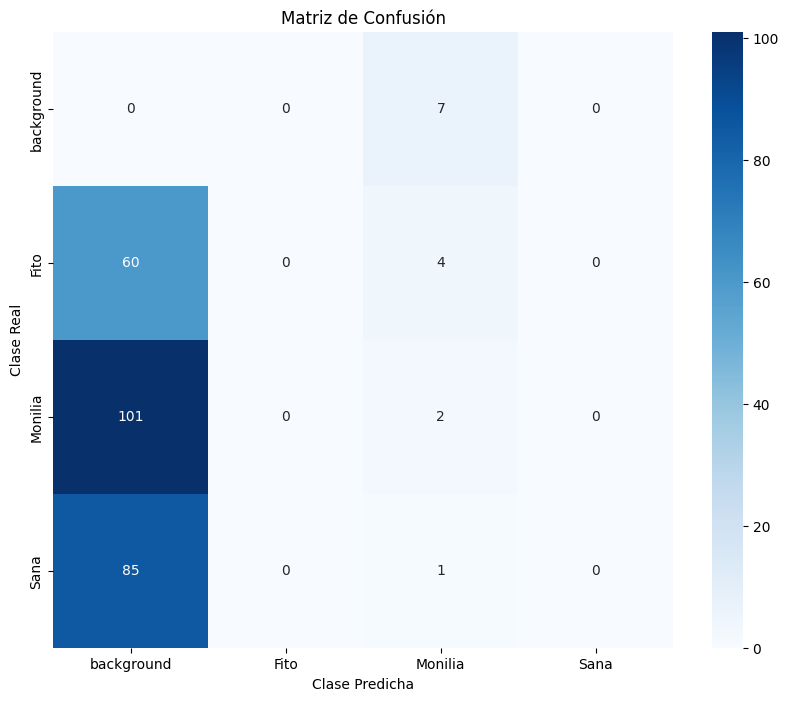

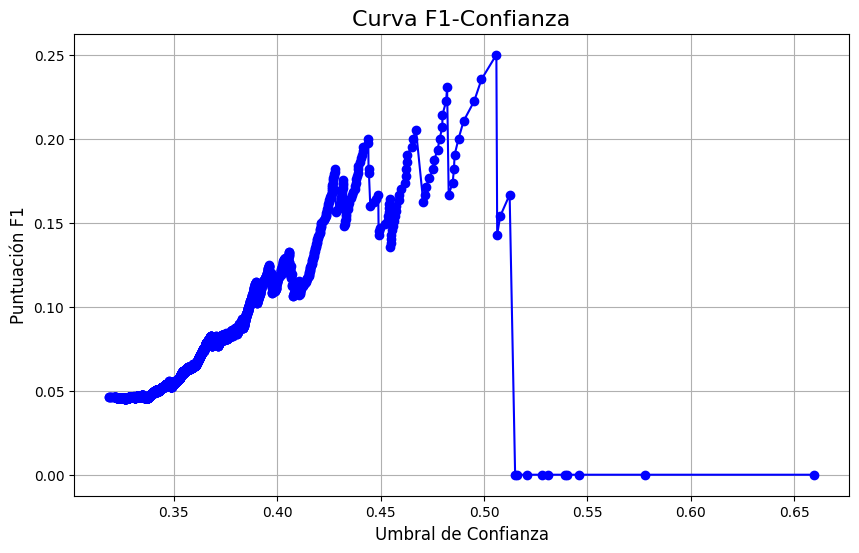

El F1 máximo es 0.2500 en un umbral de confianza de 0.5059


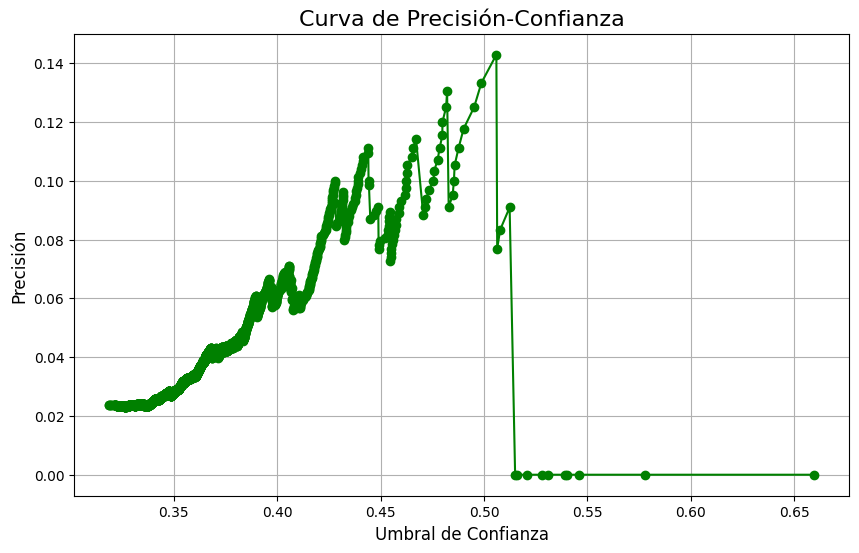

In [7]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import v2 as T
from PIL import Image
import os
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision

# Importaciones para la evaluación de COCO
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# --- Definición de las Clases y Funciones ---

class CocoaPestDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode='train', image_size=(512, 512)):
        self.root = root
        self.images_root = os.path.join(root, mode, 'images')
        self.labels_root = os.path.join(root, mode, 'labels')
        self.image_files = sorted([f for f in os.listdir(self.images_root) if f.endswith('.jpg')])
        self.image_size = image_size
        self.transforms = T.Compose([
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
            T.Resize(self.image_size) # Añadido redimensionamiento aquí
        ])

    def __getitem__(self, idx):
        # Cargar la imagen
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_root, img_file)
        img = Image.open(img_path).convert("RGB")

        original_width, original_height = img.size

        # Cargar las etiquetas del archivo .txt
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(self.labels_root, label_file)

        boxes = []
        labels = []

        if os.path.exists(label_path) and os.stat(label_path).st_size > 0:
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()

                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Coordenadas relativas
                xmin = (center_x - width / 2)
                ymin = (center_y - height / 2)
                xmax = (center_x + width / 2)
                ymax = (center_y + height / 2)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id + 1)

        # Escalar las cajas delimitadoras a la nueva resolución
        boxes = np.array(boxes)
        if boxes.size > 0:
            boxes[:, [0, 2]] = boxes[:, [0, 2]] * self.image_size[0]
            boxes[:, [1, 3]] = boxes[:, [1, 3]] * self.image_size[1]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        masks = torch.zeros((len(boxes), self.image_size[1], self.image_size[0]), dtype=torch.uint8)
        target["masks"] = masks

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

def get_model_instance_segmentation(num_classes):
    model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# --- Configuración y Evaluación ---

num_classes = 4
model = get_model_instance_segmentation(num_classes)
model.to(torch.device('cuda'))

val_dataset = CocoaPestDataset(root='/content/drive/MyDrive/EnfermedadesCacao', mode='val')
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

model.eval()

eval_results = []
cpu_device = torch.device("cpu")

for images, targets in val_data_loader:
    images = list(img.to(torch.device('cuda')) for img in images)
    try:
        with torch.no_grad():
            outputs = model(images)
    except RuntimeError as e:
        print(f"Error en la predicción: {e}")
        print("La memoria de la GPU es insuficiente. Intenta reducir el tamaño de la imagen.")
        break

    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    targets_on_cpu = [{k: v.to(cpu_device) for k, v in t.items()} for t in targets]

    eval_results.append((targets_on_cpu, outputs))

    del images, outputs, targets, targets_on_cpu
    torch.cuda.empty_cache()

# --- Generar la Matriz de Confusión ---

class_names = ['background', 'Fito', 'Monilia', 'Sana']
num_classes = len(class_names)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
iou_threshold = 0.5
score_threshold = 0.5
matched_annotations = {}

for targets, outputs in eval_results:
    for i, target in enumerate(targets):
        image_id = target['image_id'].item()
        gt_boxes = target['boxes']
        gt_labels = target['labels']
        pred_boxes = outputs[i]['boxes']
        pred_labels = outputs[i]['labels']
        pred_scores = outputs[i]['scores']

        high_score_indices = pred_scores >= score_threshold
        pred_boxes = pred_boxes[high_score_indices]
        pred_labels = pred_labels[high_score_indices]

        matched_annotations[image_id] = [False] * len(gt_boxes)

        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            iou_matrix = torchvision.ops.box_iou(gt_boxes, pred_boxes)

            for p_idx in range(len(pred_boxes)):
                if not gt_boxes.nelement():
                    confusion_matrix[0][pred_labels[p_idx].item()] += 1
                    continue

                max_iou_gt_idx = torch.argmax(iou_matrix[:, p_idx])
                max_iou = iou_matrix[max_iou_gt_idx, p_idx]

                if max_iou >= iou_threshold:
                    gt_label = gt_labels[max_iou_gt_idx].item()
                    pred_label = pred_labels[p_idx].item()

                    if not matched_annotations[image_id][max_iou_gt_idx]:
                        confusion_matrix[gt_label][pred_label] += 1
                        matched_annotations[image_id][max_iou_gt_idx] = True
                    else:
                        confusion_matrix[0][pred_label] += 1
                else:
                    confusion_matrix[0][pred_labels[p_idx].item()] += 1

        for gt_idx in range(len(gt_boxes)):
            if not matched_annotations[image_id][gt_idx]:
                confusion_matrix[gt_labels[gt_idx].item()][0] += 1

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.show()

# --- Generar la Curva F1-Confianza ---

iou_threshold = 0.5
all_preds = []
for targets, outputs in eval_results:
    for i, target in enumerate(targets):
        gt_boxes = target['boxes']
        gt_labels = target['labels']
        pred_boxes = outputs[i]['boxes']
        pred_labels = outputs[i]['labels']
        pred_scores = outputs[i]['scores']
        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            iou_matrix = torchvision.ops.box_iou(gt_boxes, pred_boxes)
            for p_idx in range(len(pred_boxes)):
                max_iou_gt_idx = torch.argmax(iou_matrix[:, p_idx])
                max_iou = iou_matrix[max_iou_gt_idx, p_idx]
                gt_label = gt_labels[max_iou_gt_idx].item()
                pred_label = pred_labels[p_idx].item()
                is_tp = (max_iou >= iou_threshold) and (gt_label == pred_label)
                all_preds.append({'score': pred_scores[p_idx].item(), 'is_tp': is_tp, 'is_fp': not is_tp, 'is_fn': False})

        if len(gt_boxes) > len(pred_boxes):
            num_fns = len(gt_boxes) - len(pred_boxes)
            for _ in range(num_fns):
                 all_preds.append({'score': 0, 'is_tp': False, 'is_fp': False, 'is_fn': True})

all_preds.sort(key=lambda x: x['score'], reverse=True)
total_tp, total_fp, total_fn = 0, 0, 0
f1_scores = []
conf_thresholds = []

for i, pred in enumerate(all_preds):
    if pred['is_tp']: total_tp += 1
    elif pred['is_fp']: total_fp += 1
    elif pred['is_fn']: total_fn += 1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)
    conf_thresholds.append(pred['score'])

plt.figure(figsize=(10, 6))
plt.plot(conf_thresholds, f1_scores, marker='o', linestyle='-', color='b')
plt.title('Curva F1-Confianza', fontsize=16)
plt.xlabel('Umbral de Confianza', fontsize=12)
plt.ylabel('Puntuación F1', fontsize=12)
plt.grid(True)
plt.show()

max_f1 = max(f1_scores)
max_f1_idx = f1_scores.index(max_f1)
optimal_conf = conf_thresholds[max_f1_idx]
print(f"El F1 máximo es {max_f1:.4f} en un umbral de confianza de {optimal_conf:.4f}")

# --- Generar la Curva de Precisión-Confianza ---

iou_threshold = 0.5
all_preds_precision = []
for targets, outputs in eval_results:
    for i, target in enumerate(targets):
        gt_boxes = target['boxes']
        gt_labels = target['labels']
        pred_boxes = outputs[i]['boxes']
        pred_labels = outputs[i]['labels']
        pred_scores = outputs[i]['scores']
        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            iou_matrix = torchvision.ops.box_iou(gt_boxes, pred_boxes)
            for p_idx in range(len(pred_boxes)):
                max_iou_gt_idx = torch.argmax(iou_matrix[:, p_idx])
                max_iou = iou_matrix[max_iou_gt_idx, p_idx]
                gt_label = gt_labels[max_iou_gt_idx].item()
                pred_label = pred_labels[p_idx].item()
                is_tp = (max_iou >= iou_threshold) and (gt_label == pred_label)
                all_preds_precision.append({'score': pred_scores[p_idx].item(), 'is_tp': is_tp, 'is_fp': not is_tp})

all_preds_precision.sort(key=lambda x: x['score'], reverse=True)
total_tp, total_fp = 0, 0
precision_scores = []
conf_thresholds = []

for pred in all_preds_precision:
    if pred['is_tp']: total_tp += 1
    elif pred['is_fp']: total_fp += 1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    precision_scores.append(precision)
    conf_thresholds.append(pred['score'])

plt.figure(figsize=(10, 6))
plt.plot(conf_thresholds, precision_scores, marker='o', linestyle='-', color='g')
plt.title('Curva de Precisión-Confianza', fontsize=16)
plt.xlabel('Umbral de Confianza', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.grid(True)
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
